In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

Let's load dataset that covers more than 7 thousand of Trump tweets starting from the summer of 2015.

In [5]:
df = pd.read_csv('Trump_tweets.csv', 
                 dtype={'id': str, 'favorite_count': int, 'retweet_count': int})

In [6]:
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.sort_values(by='created_at')
df = df.set_index('created_at')

In [7]:
# I downloaded tweets in middle November, but let's limit dataset to his campaign,
# up to November 8
df = df[:'2016-11-08']

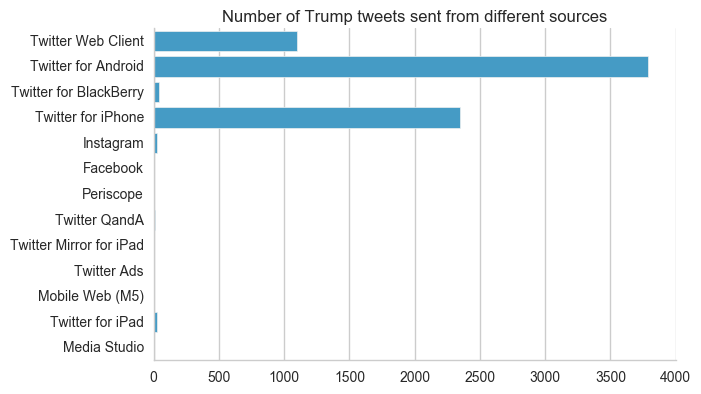

In [8]:
sns.countplot(y = df['source'], color='#30a2da')
plt.title('Number of Trump tweets sent from different sources', size=12)
plt.xlabel('')
plt.ylabel('')
sns.despine()

Trump tweets gradually became more and more popular

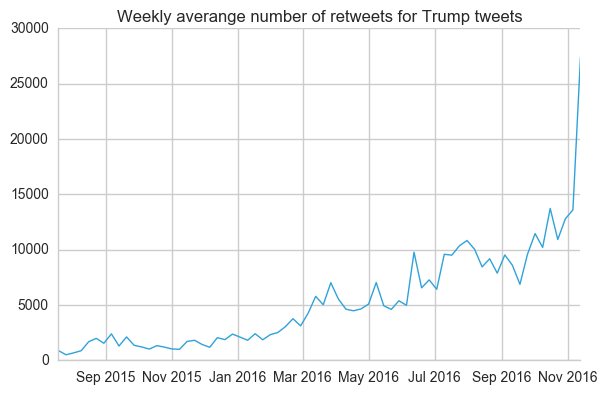

In [9]:
plt.plot(df.resample('W')['retweet_count'].mean(), lw=1)
plt.title('Weekly averange number of retweets for Trump tweets', size=12)
sns.despine()

Trump tweeted mostly from his Android phone at the beginning of campaign, but closer to the end his campaign sent more from iPhone.

In [10]:
df['source_web'] = df['source'].apply(lambda x: 1 if 'Web Client' in x else 0)
df['source_andr'] = df['source'].apply(lambda x: 1 if 'Android' in x else 0)
df['source_iph'] = df['source'].apply(lambda x: 1 if 'iPhone' in x else 0)

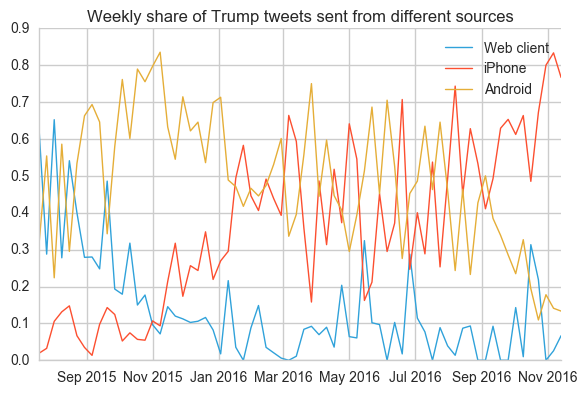

In [11]:
plt.plot(df.resample('W')['source_web'].sum()/df.resample('W').size(),
        color='#30a2da', lw=1)
plt.plot(df.resample('W')['source_iph'].sum()/df.resample('W').size(),
        color='#fc4f30', lw=1)
plt.plot(df.resample('W')['source_andr'].sum()/df.resample('W').size(),
        color='#e5ae38', lw=1)
plt.legend(labels=['Web client', 'iPhone', 'Android'])
plt.title('Weekly share of Trump tweets sent from different sources', size=12)
sns.despine()

Final campaign spur witnessed large amount of tweets sent from iPhone as well as declining ratio of favorites to retweets.

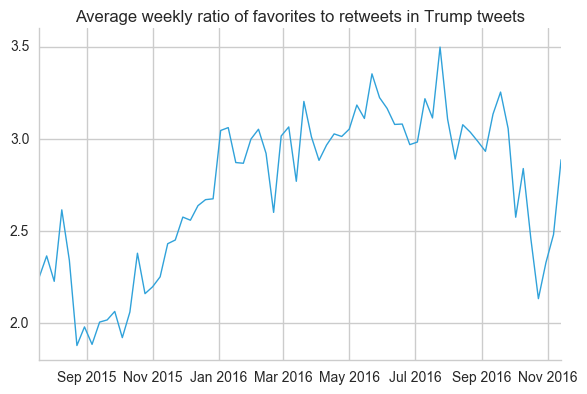

In [12]:
plt.plot(df.assign(rt_ratio=df['favorite_count']/df['retweet_count'])
         .resample('W')['rt_ratio']
         .mean(), lw=1)
plt.title('Average weekly ratio of favorites to retweets in Trump tweets', size=12)
sns.despine(top=True)

Even tweet length varied slightly with campaign.

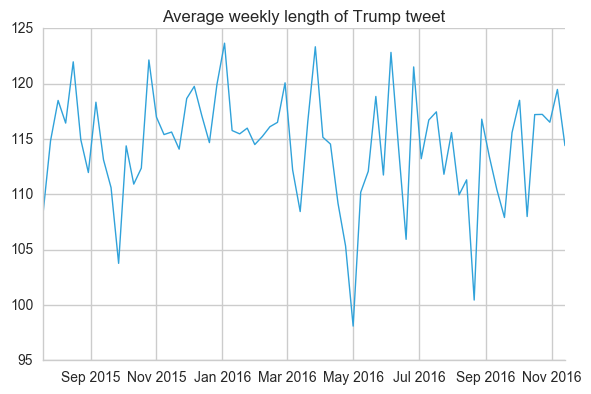

In [13]:
df['twlen'] = df['text'].apply(lambda x: len(x))
plt.plot(df.resample('W')['twlen'].mean(), lw=1)
plt.title('Average weekly length of Trump tweet', size=12)
sns.despine()

Trump loved to retweet more at the beginning and towards the end of his campaign.

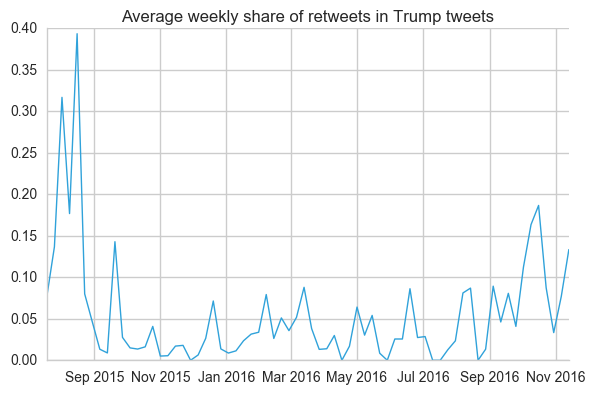

In [14]:
plt.plot((df.resample('W')['is_retweet']
 .agg(['count', 'sum'])
 .assign(ratio = lambda x: x['sum']/x['count']))['ratio'], lw=1)
plt.title('Average weekly share of retweets in Trump tweets', size=12)
sns.despine()

Increasing attacks on Clintons in the end were probably effective.

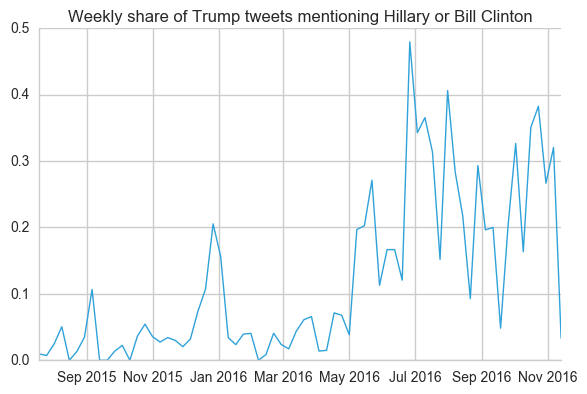

In [15]:
df['hill'] = df['text'].apply(lambda x: 1 if (('Clinton' in x) or ('Hillary' in x)) else 0)
plt.plot(df.resample('W')['hill'].sum()/df.resample('W').size(), lw=1)
plt.title('Weekly share of Trump tweets mentioning Hillary or Bill Clinton', size=12)
sns.despine()

Also, he loved his slogan "Make America great again" more and more.

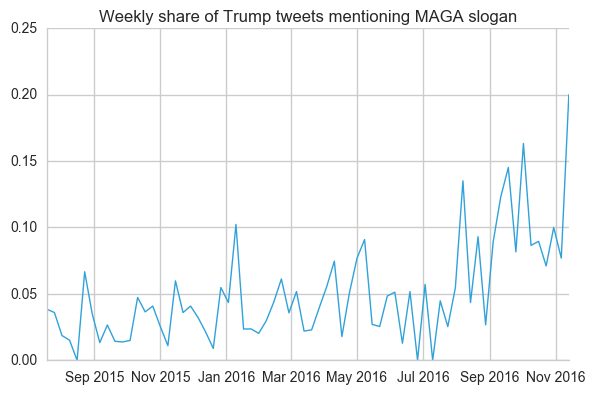

In [16]:
df['maga'] = df['text'].apply(
    lambda x: 1 if (('maga' in x.lower()) or ('make america great again' in x.lower())) 
    else 0)
plt.plot(df.resample('W')['maga'].sum()/df.resample('W').size(), lw=1)
plt.title('Weekly share of Trump tweets mentioning MAGA slogan', size=12)
sns.despine()

Now a little analysis of word usage.

In [17]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import nltk

Tokenize tweets:

In [18]:
raw_tweets = [tweet for tweet in df.text]
tok_tweets = [nltk.RegexpTokenizer(r'\w+').tokenize(tweet) for tweet in raw_tweets]

Separately, let's get usernames and hashtags in Trump tweets. We also could get and analyze all of the links, but they're shortened, so not informative.

In [19]:
def get_users(raw_tweet):
    words = raw_tweet.split(' ')
    return [word.strip(' :.,') for word in words if word.startswith('@')]

def get_hashtags(raw_tweet):
    words = raw_tweet.split(' ')
    return [word for word in words if word.startswith('#')]

hashtags = [get_hashtags(tweet) for tweet in raw_tweets]
usernames = [get_users(tweet) for tweet in raw_tweets]

Tokenize hashtags and usernames.

In [37]:
tok_hash = [nltk.RegexpTokenizer(r'\w+').tokenize(hashtag) 
            for hashlist in hashtags for hashtag in hashlist]
tok_users = [nltk.RegexpTokenizer(r'\w+').tokenize(username) 
            for userlist in usernames for username in userlist]

First, some simple word frequencies.

In [26]:
all_words = [w.lower() for tweet in tok_tweets for w in tweet]

from nltk.corpus import stopwords
stop_plus = ['http', 'co', 'u', 'donald', 'trump2016', 
             'https', 'rt', 'realdonaldtrump', 'amp', 'trump']
to_remove = stopwords.words('english') + stop_plus
trump_words = [w for w in all_words if not w in to_remove]

In [39]:
from nltk import FreqDist
trumpdist = FreqDist(trump_words)

trumpfreq = pd.DataFrame.from_dict({k:v for k,v in trumpdist.most_common(50)}, 
                       orient='index').rename(columns={0: 'counts'})

Which words, apart from links and stopwords, did Trump use the most?

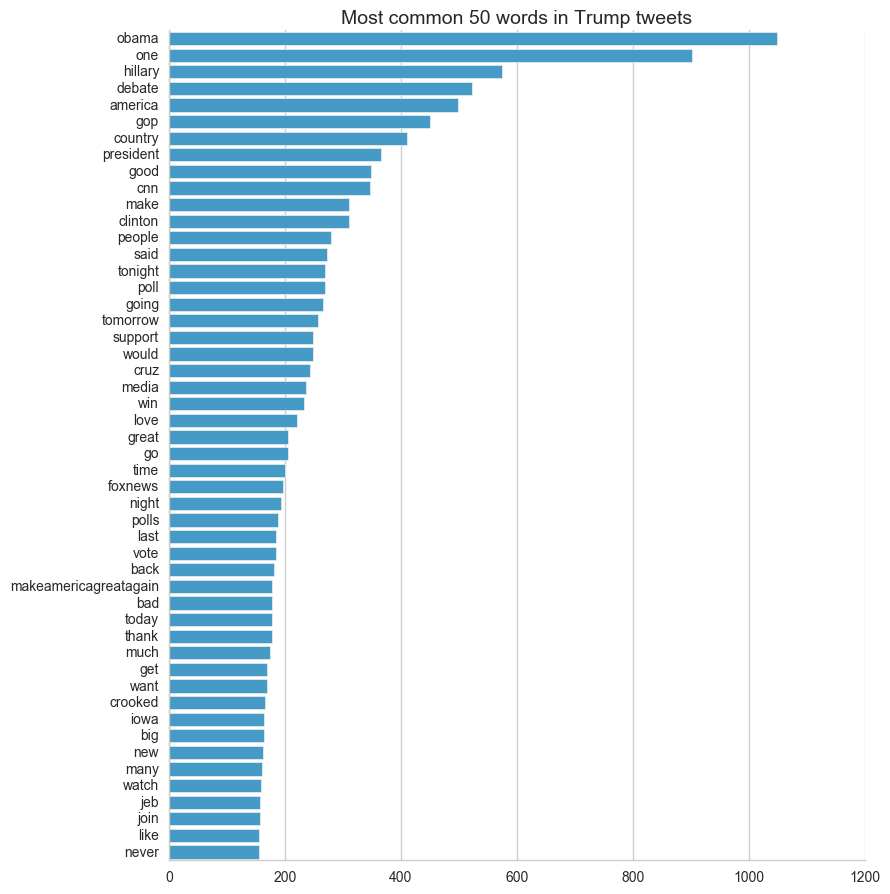

In [28]:
fig, ax1 = plt.subplots(figsize=(8,10))
sns.barplot(data=trumpfreq.sort_values(by='counts', ascending=False), y=trumpfreq.index, 
            x='counts', color='#30a2da')
plt.title('Most common 50 words in Trump tweets', size=14)
plt.xlabel('')
sns.despine()

Yep, it's never getting good to watch crooked Hillary go today :(

In [55]:
all_hash = [h for hashlist in tok_hash for h in hashlist]
all_hash = [h for h in all_hash if h not in ['s', 'https', 'co', 't']]
hashfreq = pd.DataFrame.from_dict({k:v for k,v in FreqDist(all_hash).most_common(20)}, 
                       orient='index').rename(columns={0: 'counts'})

Nothing surprising in most popular Trump hashtags:

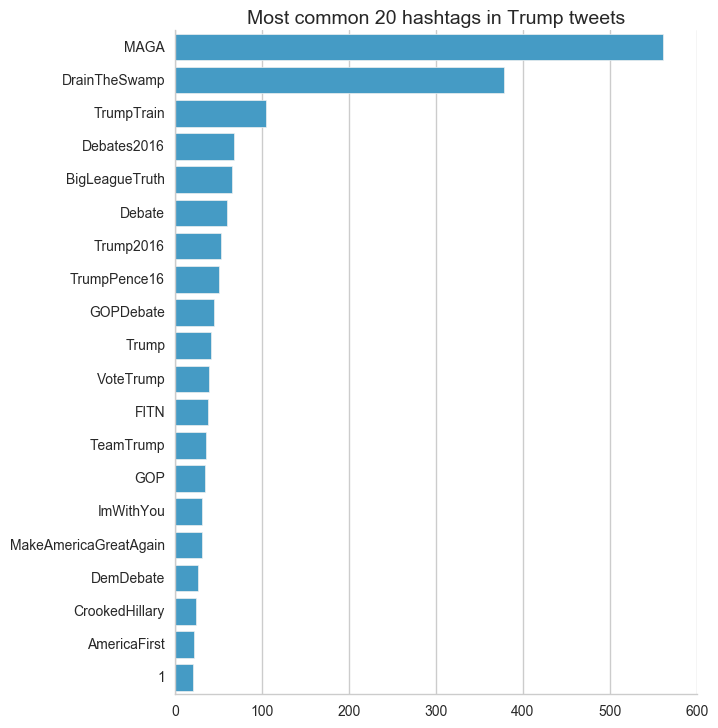

In [57]:
fig, ax2 = plt.subplots(figsize=(6,8))
sns.barplot(data=hashfreq.sort_values(by='counts', ascending=False), y=hashfreq.index, 
            x='counts', color='#30a2da')
plt.title('Most common 20 hashtags in Trump tweets', size=14)
plt.xlabel('')
sns.despine()

In [66]:
all_user = [u for userlist in tok_users for u in userlist]
all_user = [u for u in all_user if u not in ['s', 't']]
userfreq = pd.DataFrame.from_dict({k:v for k,v in FreqDist(all_user).most_common(30)}, 
                       orient='index').rename(columns={0: 'counts'})

It looks like Trump especially likes to read ABC news twitter.

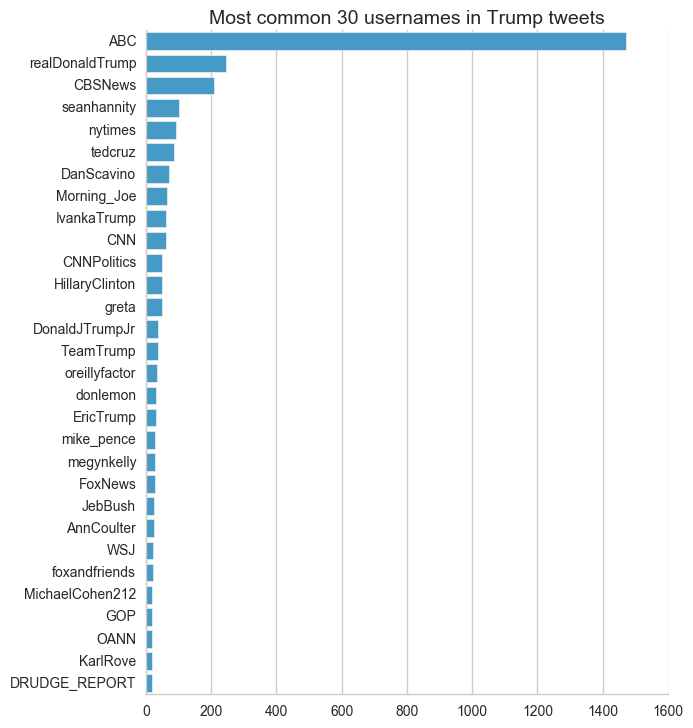

In [67]:
fig, ax3 = plt.subplots(figsize=(6,8))
sns.barplot(data=userfreq.sort_values(by='counts', ascending=False), y=userfreq.index, 
            x='counts', color='#30a2da')
plt.title('Most common 30 usernames in Trump tweets', size=14)
plt.xlabel('')
sns.despine()